# HMI SPINN

In [ ]:
from setproctitle import setproctitle

setproctitle("HMI SPINN")

In [ ]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "2"

In [ ]:
from zpinn.pinn_nf2_cleanup import create_coordinates
from zpinn.spinn_cleanup_new import SPINN3d, generate_train_data, apply_model_spinn, update_model

In [ ]:
import jax 
import jax.numpy as jnp
import optax
import numpy as np 
import matplotlib.pyplot as plt
import time 
import pickle
from tqdm import trange

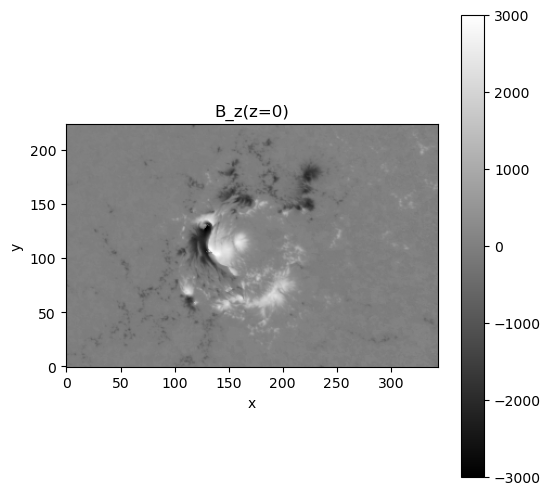

In [ ]:
input_path = '01_input/AR7115_20170906_090000/'
bottom_npy_path = os.path.join(input_path, 'b_bottom.npy')

with open(bottom_npy_path, 'rb') as f:
        b_bottom = np.load(f)

plt.close()
fig, ax = plt.subplots(figsize=(6,6))
CS = plt.imshow(b_bottom[:, :, 2].transpose(), origin='lower', cmap='gray', vmin=-3000, vmax=3000)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title("B_z(z=0)")
fig.colorbar(CS)
plt.show()

In [ ]:
output_path = '02_output/AR7115_20170906_090000/SPINN'

Nx, Ny, _ = b_bottom.shape
Nz = 160

spatial_norm = 160
b_norm = 2500

In [ ]:
boundary_path = os.path.join(output_path, 'boundary')
os.makedirs(boundary_path, exist_ok=True)
boundary_npy_path = os.path.join(boundary_path, 'boundary_data.pickle')

# b_bottom_norm_path = os.path.join(boundary_path, 'b_bottom_norm.npy')
# bp_top_norm_path = os.path.join(boundary_path, 'b_top_norm.npy')
# bp_lateral_1_norm_path = os.path.join(boundary_path, 'b_lateral_1_norm.npy')
# bp_lateral_2_norm_path = os.path.join(boundary_path, 'b_lateral_2_norm.npy')
# bp_lateral_3_norm_path = os.path.join(boundary_path, 'b_lateral_3_norm.npy')
# bp_lateral_4_norm_path = os.path.join(boundary_path, 'b_lateral_4_norm.npy')

In [ ]:
epochs = 10000
log_iter = 1000

features = 256
n_layers = 8 
feat_sizes = tuple([features for _ in range(n_layers)]) 
r = 128 
out_dim = 3 

lr = 5e-4

## Create boundary data

In [ ]:
from zpinn.create_pot import get_potential_boundary

In [ ]:
coords, fields = get_potential_boundary(b_bottom[:, :, 2], Nz)

bp_top = fields[0]
bp_lateral_3 = fields[1]
bp_lateral_4 = fields[2]
bp_lateral_1 = fields[3]
bp_lateral_2 = fields[4]

b_bottom_norm = b_bottom / b_norm
bp_top_norm = bp_top / b_norm
bp_lateral_1_norm = bp_lateral_1 / b_norm
bp_lateral_2_norm = bp_lateral_2 / b_norm
bp_lateral_3_norm = bp_lateral_3 / b_norm 
bp_lateral_4_norm = bp_lateral_4 / b_norm

boundary_data = (b_bottom_norm, bp_top_norm, bp_lateral_1_norm, bp_lateral_2_norm, bp_lateral_3_norm, bp_lateral_4_norm)

with open(boundary_npy_path, "wb") as f:
    pickle.dump(boundary_data, f)

# with open(b_bottom_norm_path, 'wb') as f:
#         np.save(f, b_bottom_norm)

# with open(bp_top_norm_path, 'wb') as f:
#         np.save(f, bp_top_norm)

# with open(bp_lateral_1_norm_path, 'wb') as f:
#         np.save(f, bp_lateral_1_norm)

# with open(bp_lateral_2_norm_path, 'wb') as f:
#         np.save(f, bp_lateral_2_norm)

# with open(bp_lateral_3_norm_path, 'wb') as f:
#         np.save(f, bp_lateral_3_norm)

# with open(bp_lateral_4_norm_path, 'wb') as f:
#         np.save(f, bp_lateral_4_norm)

Potential Field: 100%|██████████| 380/380 [00:39<00:00,  9.71it/s]


## SPINN

In [ ]:
with open(boundary_npy_path, 'rb') as f:
        boundary_data = pickle.load(f)

# with open(b_bottom_norm_path, 'rb') as f:
#         b_bottom_norm = np.load(f)

# with open(bp_top_norm_path, 'rb') as f:
#         bp_top_norm = np.load(f)

# with open(bp_lateral_1_norm_path, 'rb') as f:
#         bp_lateral_1_norm = np.load(f)

# with open(bp_lateral_2_norm_path, 'rb') as f:
#         bp_lateral_2_norm = np.load(f)

# with open(bp_lateral_3_norm_path, 'rb') as f:
#         bp_lateral_3_norm = np.load(f)

# with open(bp_lateral_4_norm_path, 'rb') as f:
#         bp_lateral_4_norm = np.load(f)

In [ ]:
seed = 111
key = jax.random.PRNGKey(seed)
key, subkey = jax.random.split(key, 2)

In [ ]:
model = SPINN3d(feat_sizes, r, out_dim, pos_enc=0, mlp='modified_mlp')
params = model.init(
            subkey,
            jnp.ones((Nx, 1)),
            jnp.ones((Ny, 1)),
            jnp.ones((Nz, 1))
        )
apply_fn = jax.jit(model.apply)
optim = optax.adam(learning_rate=lr)
state = optim.init(params)

In [ ]:
params_path = os.path.join(output_path, "params_0.pickle")
with open(params_path, "wb") as f:
    pickle.dump(params, f)

In [ ]:
key, subkey = jax.random.split(key, 2)
train_data = generate_train_data(Nx, Ny, Nz, key)
train_boundary_data = [train_data, boundary_data]

In [ ]:
losses = []

In [ ]:
loss, gradient = apply_model_spinn(apply_fn, params, train_boundary_data)
losses.append(loss.item())
params, state = update_model(optim, gradient, params, state)

In [ ]:
start = time.time()
for e in trange(1, epochs + 1):
    
    # if e % 300 == 0:
    #     # sample new input data
    #     key, subkey = jax.random.split(key, 2)
    #     train_data = generate_train_data(nx, ny, nz, subkey)

    loss, gradient = apply_model_spinn(apply_fn, params, train_boundary_data)
    losses.append(loss.item())
    params, state = update_model(optim, gradient, params, state)
    
    if e % log_iter == 0:
        print(f'Epoch: {e}/{epochs} --> total loss: {loss:.8f}')
        params_path = os.path.join(output_path, f"params_{e}.pickle")
        with open(params_path, "wb") as f:
            pickle.dump(params, f)

np.save(os.path.join(output_path, 'losses.npy'), losses)
runtime = time.time() - start
print(f'Runtime --> total: {runtime:.2f}sec ({(runtime/(epochs-1)*1000):.2f}ms/iter.)')

 10%|█         | 1002/10000 [00:45<07:12, 20.82it/s]

Epoch: 1000/10000 --> total loss: 0.01865177


 20%|██        | 2001/10000 [01:31<06:47, 19.62it/s]

Epoch: 2000/10000 --> total loss: 0.01293330


 30%|███       | 3003/10000 [02:17<05:27, 21.34it/s]

Epoch: 3000/10000 --> total loss: 0.01030624


 40%|████      | 4002/10000 [03:02<04:42, 21.23it/s]

Epoch: 4000/10000 --> total loss: 0.00898545


 50%|█████     | 5004/10000 [03:48<03:54, 21.35it/s]

Epoch: 5000/10000 --> total loss: 0.00827396


 60%|██████    | 6003/10000 [04:34<03:08, 21.22it/s]

Epoch: 6000/10000 --> total loss: 0.00779266


 70%|███████   | 7002/10000 [05:20<02:20, 21.31it/s]

Epoch: 7000/10000 --> total loss: 0.00730471


 80%|████████  | 8004/10000 [06:07<01:33, 21.45it/s]

Epoch: 8000/10000 --> total loss: 0.00687852


 90%|█████████ | 9003/10000 [06:53<00:46, 21.47it/s]

Epoch: 9000/10000 --> total loss: 0.00657744


100%|██████████| 10000/10000 [07:38<00:00, 21.80it/s]

Epoch: 10000/10000 --> total loss: 0.00636160
Runtime --> total: 458.81sec (45.89ms/iter.)


In [ ]:
with open(os.path.join(output_path, 'losses.npy'), "rb") as f:
        losses = np.load(f)

Text(0, 0.5, 'Loss')

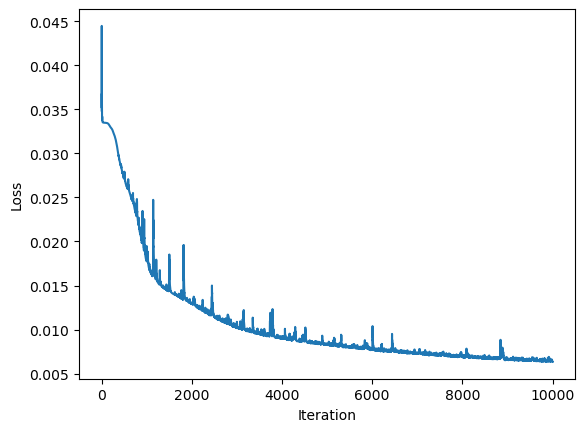

In [ ]:
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')

## Viz

In [ ]:
import pyvista as pv
from zpinn.pinn_nf2_visualization import draw_grid
from zpinn.spinn_cleanup import load_spinn_mag

In [ ]:
pv.start_xvfb()
pv.global_theme.trame.server_proxy_enabled = True
pv.set_jupyter_backend('static')

In [ ]:
eval_path = '03_eval/AR7115_20170906_090000/SPINN'
os.makedirs(eval_path, exist_ok=True)
vtk_path = os.path.join(eval_path, f'B_spinn_{epochs}.vtk')

### vtk

In [ ]:
def ctr_mesh(vtk_path, param_path, Nx, Ny, Nz, b_norm):
    with open(param_path,"rb") as f:
        params = pickle.load(f)

    B = load_spinn_mag(param_path, Nx, Ny, Nz, b_norm)

    Bx = B[..., 0]
    By = B[..., 1]
    Bz = B[..., 2]

    co_bounds = (0, Nx-1, 0, Ny-1, 0, Nz-1)
    co_coords = create_coordinates(co_bounds).reshape(-1, 3)
    co_coord = co_coords.reshape(Nx, Ny, Nz, 3)
    x = co_coord[..., 0]
    y = co_coord[..., 1]
    z = co_coord[..., 2]
    mesh = pv.StructuredGrid(x, y, z)
    vectors = np.stack([Bx, By, Bz], axis=-1).transpose(2, 1, 0, 3).reshape(-1, 3)
    mesh['B'] = vectors
    mesh.active_vectors_name = 'B'
    magnitude = np.linalg.norm(vectors, axis=-1)
    mesh['mag'] = magnitude
    mesh.active_scalars_name = 'mag'
    mesh.save(vtk_path)

In [ ]:
iterations = np.arange(0, epochs+1, log_iter)

for epo in iterations:
    param_path = os.path.join(output_path, f"params_{epo}.pickle")
    vtk_paths = os.path.join(eval_path, f'B_spinn_{epo}.vtk')
    ctr_mesh(vtk_paths, param_path, Nx, Ny, Nz, b_norm)
    print(epo)

In [ ]:
# param_path = os.path.join(output_path, f"params_{epochs}.pickle")

# with open(param_path,"rb") as f:
#     params = pickle.load(f)

# B = load_spinn_mag(param_path, Nx, Ny, Nz, b_norm)

# Bx = B[..., 0]
# By = B[..., 1]
# Bz = B[..., 2]

# co_bounds = (0, Nx-1, 0, Ny-1, 0, Nz-1)
# co_coords = create_coordinates(co_bounds).reshape(-1, 3)
# co_coord = co_coords.reshape(Nx, Ny, Nz, 3)
# x = co_coord[..., 0]
# y = co_coord[..., 1]
# z = co_coord[..., 2]
# mesh = pv.StructuredGrid(x, y, z)
# vectors = np.stack([Bx, By, Bz], axis=-1).transpose(2, 1, 0, 3).reshape(-1, 3)
# mesh['B'] = vectors
# mesh.active_vectors_name = 'B'
# magnitude = np.linalg.norm(vectors, axis=-1)
# mesh['mag'] = magnitude
# mesh.active_scalars_name = 'mag'

# mesh

StructuredGrid (0x7f5d706080a0)
  N Cells:      12161751
  N Points:     12328960
  X Bounds:     0.000e+00, 3.430e+02
  Y Bounds:     0.000e+00, 2.230e+02
  Z Bounds:     0.000e+00, 1.590e+02
  Dimensions:   344, 224, 160
  N Arrays:     2

In [ ]:
# mesh.save(vtk_path)

### load

In [ ]:
B_spinn_mesh = pv.read(vtk_path)

In [ ]:
B_spinn_mesh.bounds

(0.0, 343.0, 0.0, 223.0, 0.0, 159.0)

In [ ]:
B_spinn_grid = draw_grid(B_spinn_mesh)

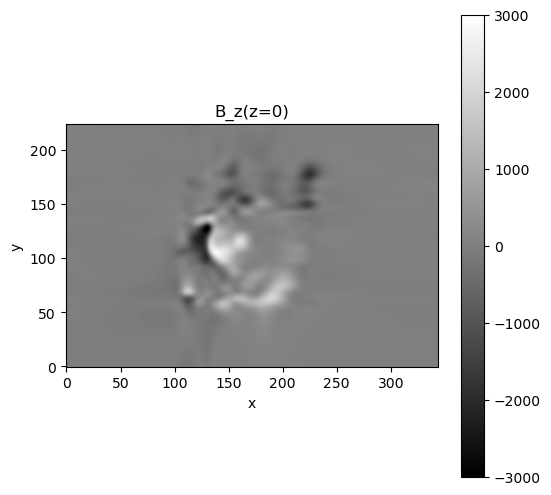

In [ ]:
B_spinn_grid.plt_Bz_imshow(z=0, vmin=-3000, vmax=3000)

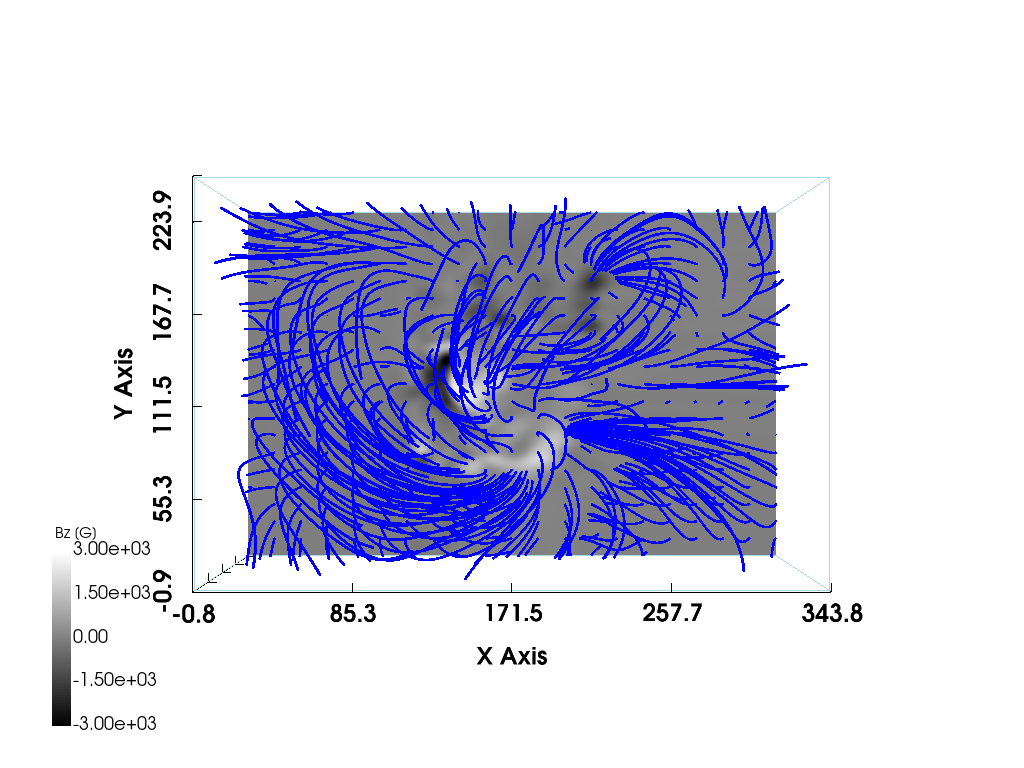

In [ ]:
B_spinn_grid.pv_streamline_Bz(camera_position='xy', i_resolution=20, j_resolution=20, vmin=-3000, vmax=3000)

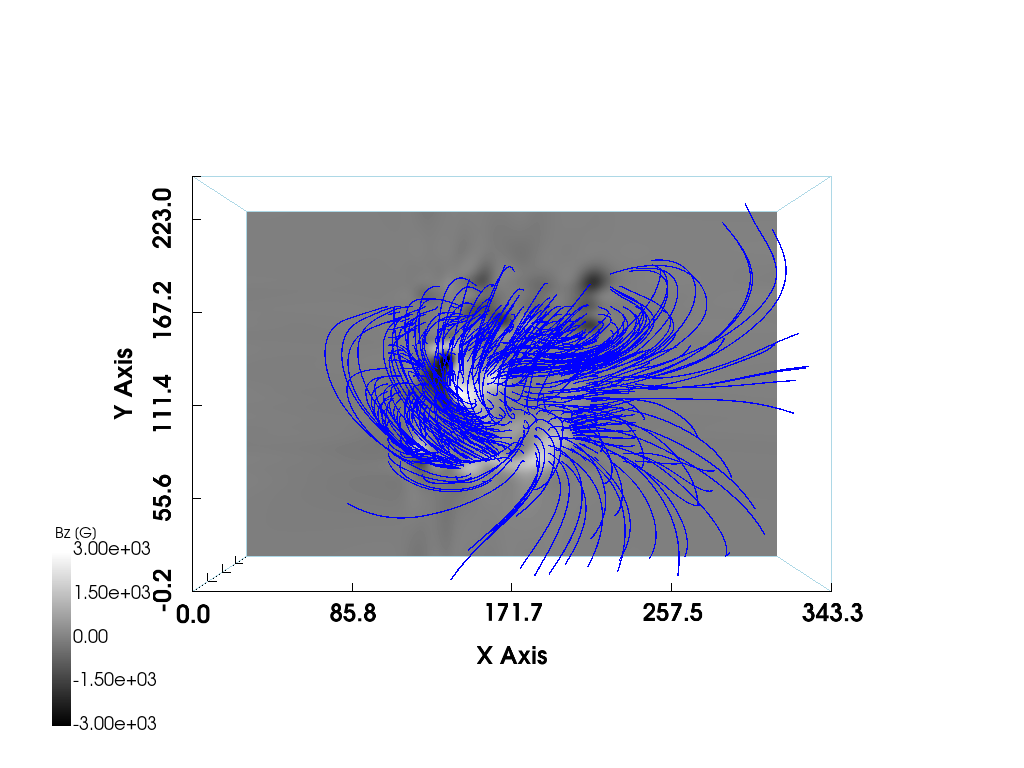

In [ ]:
B_spinn_grid.pv_streamline_Bz(camera_position='xy', i_siz=160, j_siz=100, i_resolution=20, j_resolution=20, vmin=-3000, vmax=3000)